# Imports

In [ ]:
!pip install keras_unet_collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from datetime import datetime
from PIL import Image
import random
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU

from keras_unet_collection import losses

from sklearn.model_selection import train_test_split

# Get dataset

In [ ]:
!wget -O augmented_dataset3200.zip https://www.dropbox.com/s/dbu916o3ki5fh5j/augmented_dataset3200.zip?dl=0
!unzip /content/augmented_dataset3200.zip

## Process images

In [ ]:
augmented_images_dir_path = "/content/augmented_images"
augmented_masks_dir_path =  "/content/augmented_masks"

In [ ]:
image_names = glob.glob(f"{augmented_images_dir_path}/*.jpg")
image_names.sort()


image_dataset = []

for image_name in image_names:
      image = cv2.imread(image_name, 1)
      image = Image.fromarray(image)
      image_dataset.append(np.array(image))

In [ ]:
mask_names = glob.glob(f"{augmented_masks_dir_path}/*.png")
mask_names.sort()

mask_dataset = []

for image_name in mask_names:
        image = cv2.imread(image_name, 0)
        image = np.where(image>0, 255, image)
        image = Image.fromarray(image)
        mask_dataset.append(np.array(image))

In [ ]:
names = []
for i in range(len(os.listdir(augmented_masks_dir_path))):
  img_name = image_names[i].split("/")[-1]
  mask_name = mask_names[i].split("/")[-1]

  n1 = img_name.split(".")[0]
  n2 = mask_name.split(".")[0]
  names.append(n1==n2)

all(names)

True

In [ ]:
image_dataset = np.array(image_dataset)/255.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

#Split data for train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 9)

In [ ]:
X_train.shape

(2560, 256, 256, 3)

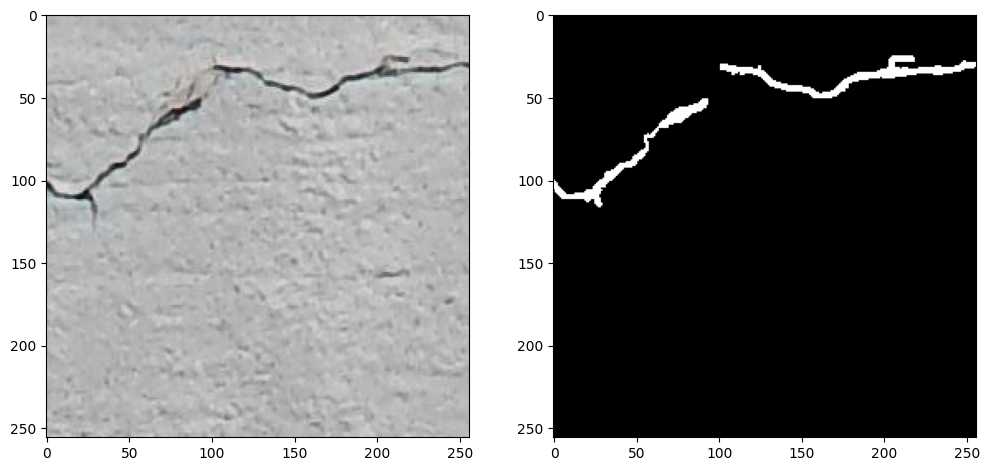

In [ ]:
#Sanity check
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

#U-Net

## Settings

In [ ]:
metrics_set=[ tf.keras.metrics.BinaryIoU(target_class_ids=[1]), losses.dice_coef]

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
num_labels = 1  #Binary
batch_size = 16
epochs = 50

In [ ]:
!mkdir /content/unet_checkpoints

filepath = '/content/unet_checkpoints/unet_model.h5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor="val_dice_coef",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlyStopping = EarlyStopping(patience=5)

callbacks = [checkpoint, earlyStopping]

## Fitting

In [ ]:
from keras_unet_collection.models import unet_2d

In [ ]:
model = unet_2d((
                  256, 256, 3),
                  [64, 128, 256, 512, 1024],
                  n_labels=1,
                  stack_num_down=2,
                  stack_num_up=1,
                  activation='ReLU',
                  output_activation='Sigmoid',
                  batch_norm=True,
                  pool=False,
                  unpool=False,
                  backbone='VGG16',
                  weights='imagenet',
                  freeze_backbone=True,
                  freeze_batch_norm=True,
                  name='unet'
                  )

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=metrics_set)

In [ ]:
start = datetime.now()
history = model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    epochs=epochs,
                    callbacks=callbacks)

stop = datetime.now()

Epoch 1/50
160/160 [==============================] - ETA: 0s - loss: 0.2013 - binary_io_u: 0.3000 - dice_coef: 0.1267
Epoch 1: val_dice_coef improved from -inf to 0.07672, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 72s 322ms/step - loss: 0.2013 - binary_io_u: 0.3000 - dice_coef: 0.1267 - val_loss: 0.3379 - val_binary_io_u: 0.4275 - val_dice_coef: 0.0767
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.0773 - binary_io_u: 0.6715 - dice_coef: 0.2186
Epoch 2: val_dice_coef improved from 0.07672 to 0.17547, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 58s 362ms/step - loss: 0.0773 - binary_io_u: 0.6715 - dice_coef: 0.2186 - val_loss: 0.1036 - val_binary_io_u: 0.7193 - val_dice_coef: 0.1755
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.0572 - binary_io_u: 0.7096 - dice_coef: 0.2732
Epoch 3: val_dice_coef improved from 0.17547 to 0.24795, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 56s 350ms/step - loss: 0.0572 - binary_io_u: 0.7096 - dice_coef: 0.2732 - val_loss: 0.0609 - val_binary_io_u: 0.7176 - val_dice_coef: 0.2480
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.0464 - binary_io_u: 0.7286 - dice_coef: 0.3219
Epoch 4: val_dice_coef improved from 0.24795 to 0.29231, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 51s 318ms/step - loss: 0.0464 - binary_io_u: 0.7286 - dice_coef: 0.3219 - val_loss: 0.0482 - val_binary_io_u: 0.7240 - val_dice_coef: 0.2923
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.0392 - binary_io_u: 0.7361 - dice_coef: 0.3687
Epoch 5: val_dice_coef improved from 0.29231 to 0.37708, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 58s 361ms/step - loss: 0.0392 - binary_io_u: 0.7361 - dice_coef: 0.3687 - val_loss: 0.0370 - val_binary_io_u: 0.7429 - val_dice_coef: 0.3771
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.0328 - binary_io_u: 0.7482 - dice_coef: 0.4115
Epoch 6: val_dice_coef improved from 0.37708 to 0.39057, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 52s 324ms/step - loss: 0.0328 - binary_io_u: 0.7482 - dice_coef: 0.4115 - val_loss: 0.0319 - val_binary_io_u: 0.7345 - val_dice_coef: 0.3906
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.0280 - binary_io_u: 0.7570 - dice_coef: 0.4526
Epoch 7: val_dice_coef improved from 0.39057 to 0.46105, saving model to /content/unet_checkpoints/unet_model.h5
160/160 [==============================] - 56s 351ms/step - loss: 0.0280 - binary_io_u: 0.7570 - dice_coef: 0.4526 - val_loss: 0.0252 - val_binary_io_u: 0.7427 - val_dice_coef: 0.4611
Epoch 8/50
  1/160 [..............................] - ETA: 30s - loss: 0.0230 - binary_io_u: 0.7452 - dice_coef: 0.3674

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - ETA: 0s - loss: 0.0244 - binary_io_u: 0.7632 - dice_coef: 0.4889
Epoch 8: val_dice_coef improved from 0.46105 to 0.50364, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 56s 348ms/step - loss: 0.0244 - binary_io_u: 0.7632 - dice_coef: 0.4889 - val_loss: 0.0227 - val_binary_io_u: 0.7581 - val_dice_coef: 0.5036
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.0215 - binary_io_u: 0.7687 - dice_coef: 0.5257
Epoch 9: val_dice_coef did not improve from 0.50364
160/160 [==============================] - 53s 332ms/step - loss: 0.0215 - binary_io_u: 0.7687 - dice_coef: 0.5257 - val_loss: 0.0238 - val_binary_io_u: 0.7621 - val_dice_coef: 0.4935
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.0193 - binary_io_u: 0.7737 - dice_coef: 0.5581
Epoch 10: val_dice_coef improved from 0.50364 to 0.55522, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 58s 365ms/step - loss: 0.0193 - binary_io_u: 0.7737 - dice_coef: 0.5581 - val_loss: 0.0187 - val_binary_io_u: 0.7597 - val_dice_coef: 0.5552
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.0176 - binary_io_u: 0.7721 - dice_coef: 0.5824
Epoch 11: val_dice_coef improved from 0.55522 to 0.58111, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 57s 357ms/step - loss: 0.0176 - binary_io_u: 0.7721 - dice_coef: 0.5824 - val_loss: 0.0167 - val_binary_io_u: 0.7455 - val_dice_coef: 0.5811
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.0164 - binary_io_u: 0.7716 - dice_coef: 0.6046
Epoch 12: val_dice_coef improved from 0.58111 to 0.59406, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 50s 316ms/step - loss: 0.0164 - binary_io_u: 0.7716 - dice_coef: 0.6046 - val_loss: 0.0167 - val_binary_io_u: 0.7593 - val_dice_coef: 0.5941
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.0148 - binary_io_u: 0.7786 - dice_coef: 0.6307
Epoch 13: val_dice_coef improved from 0.59406 to 0.61936, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 52s 326ms/step - loss: 0.0148 - binary_io_u: 0.7786 - dice_coef: 0.6307 - val_loss: 0.0148 - val_binary_io_u: 0.7478 - val_dice_coef: 0.6194
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.0137 - binary_io_u: 0.7829 - dice_coef: 0.6541
Epoch 14: val_dice_coef improved from 0.61936 to 0.63998, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 345ms/step - loss: 0.0137 - binary_io_u: 0.7829 - dice_coef: 0.6541 - val_loss: 0.0142 - val_binary_io_u: 0.7631 - val_dice_coef: 0.6400
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.0128 - binary_io_u: 0.7845 - dice_coef: 0.6712
Epoch 15: val_dice_coef improved from 0.63998 to 0.66062, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 347ms/step - loss: 0.0128 - binary_io_u: 0.7845 - dice_coef: 0.6712 - val_loss: 0.0137 - val_binary_io_u: 0.7658 - val_dice_coef: 0.6606
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.0121 - binary_io_u: 0.7851 - dice_coef: 0.6881
Epoch 16: val_dice_coef improved from 0.66062 to 0.68733, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 58s 363ms/step - loss: 0.0121 - binary_io_u: 0.7851 - dice_coef: 0.6881 - val_loss: 0.0123 - val_binary_io_u: 0.7647 - val_dice_coef: 0.6873
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.0113 - binary_io_u: 0.7889 - dice_coef: 0.7045
Epoch 17: val_dice_coef improved from 0.68733 to 0.70047, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 52s 324ms/step - loss: 0.0113 - binary_io_u: 0.7889 - dice_coef: 0.7045 - val_loss: 0.0117 - val_binary_io_u: 0.7671 - val_dice_coef: 0.7005
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.0108 - binary_io_u: 0.7895 - dice_coef: 0.7192
Epoch 18: val_dice_coef improved from 0.70047 to 0.70344, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 49s 307ms/step - loss: 0.0108 - binary_io_u: 0.7895 - dice_coef: 0.7192 - val_loss: 0.0115 - val_binary_io_u: 0.7609 - val_dice_coef: 0.7034
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 0.0103 - binary_io_u: 0.7920 - dice_coef: 0.7295
Epoch 19: val_dice_coef improved from 0.70344 to 0.72336, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 49s 309ms/step - loss: 0.0103 - binary_io_u: 0.7920 - dice_coef: 0.7295 - val_loss: 0.0109 - val_binary_io_u: 0.7558 - val_dice_coef: 0.7234
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 0.0100 - binary_io_u: 0.7901 - dice_coef: 0.7370
Epoch 20: val_dice_coef improved from 0.72336 to 0.72801, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 50s 311ms/step - loss: 0.0100 - binary_io_u: 0.7901 - dice_coef: 0.7370 - val_loss: 0.0108 - val_binary_io_u: 0.7636 - val_dice_coef: 0.7280
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.0095 - binary_io_u: 0.7941 - dice_coef: 0.7528
Epoch 21: val_dice_coef improved from 0.72801 to 0.74754, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 51s 319ms/step - loss: 0.0095 - binary_io_u: 0.7941 - dice_coef: 0.7528 - val_loss: 0.0101 - val_binary_io_u: 0.7611 - val_dice_coef: 0.7475
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 0.0091 - binary_io_u: 0.7968 - dice_coef: 0.7616
Epoch 22: val_dice_coef improved from 0.74754 to 0.75305, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 50s 314ms/step - loss: 0.0091 - binary_io_u: 0.7968 - dice_coef: 0.7616 - val_loss: 0.0104 - val_binary_io_u: 0.7678 - val_dice_coef: 0.7530
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.0088 - binary_io_u: 0.7981 - dice_coef: 0.7691
Epoch 23: val_dice_coef did not improve from 0.75305
160/160 [==============================] - 51s 318ms/step - loss: 0.0088 - binary_io_u: 0.7981 - dice_coef: 0.7691 - val_loss: 0.0101 - val_binary_io_u: 0.7678 - val_dice_coef: 0.7499
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 0.0084 - binary_io_u: 0.8007 - dice_coef: 0.7790
Epoch 24: val_dice_coef improved from 0.75305 to 0.77208, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 52s 328ms/step - loss: 0.0084 - binary_io_u: 0.8007 - dice_coef: 0.7790 - val_loss: 0.0098 - val_binary_io_u: 0.7646 - val_dice_coef: 0.7721
Epoch 25/50
160/160 [==============================] - ETA: 0s - loss: 0.0082 - binary_io_u: 0.8015 - dice_coef: 0.7847
Epoch 25: val_dice_coef did not improve from 0.77208
160/160 [==============================] - 56s 353ms/step - loss: 0.0082 - binary_io_u: 0.8015 - dice_coef: 0.7847 - val_loss: 0.0097 - val_binary_io_u: 0.7650 - val_dice_coef: 0.7709
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.0084 - binary_io_u: 0.7945 - dice_coef: 0.7846
Epoch 26: val_dice_coef did not improve from 0.77208
160/160 [==============================] - 55s 343ms/step - loss: 0.0084 - binary_io_u: 0.7945 - dice_coef: 0.7846 - val_loss: 0.0103 - val_binary_io_u: 0.7672 - val_dice_coef: 0.7516
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.0078 - binary_io_u: 0.8033 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 347ms/step - loss: 0.0078 - binary_io_u: 0.8033 - dice_coef: 0.7970 - val_loss: 0.0092 - val_binary_io_u: 0.7671 - val_dice_coef: 0.7815
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.0076 - binary_io_u: 0.8074 - dice_coef: 0.8036
Epoch 28: val_dice_coef improved from 0.78150 to 0.78622, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 54s 339ms/step - loss: 0.0076 - binary_io_u: 0.8074 - dice_coef: 0.8036 - val_loss: 0.0093 - val_binary_io_u: 0.7645 - val_dice_coef: 0.7862
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.0074 - binary_io_u: 0.8094 - dice_coef: 0.8091
Epoch 29: val_dice_coef improved from 0.78622 to 0.79091, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 347ms/step - loss: 0.0074 - binary_io_u: 0.8094 - dice_coef: 0.8091 - val_loss: 0.0092 - val_binary_io_u: 0.7654 - val_dice_coef: 0.7909
Epoch 30/50
160/160 [==============================] - ETA: 0s - loss: 0.0071 - binary_io_u: 0.8132 - dice_coef: 0.8150
Epoch 30: val_dice_coef improved from 0.79091 to 0.79157, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 48s 299ms/step - loss: 0.0071 - binary_io_u: 0.8132 - dice_coef: 0.8150 - val_loss: 0.0090 - val_binary_io_u: 0.7640 - val_dice_coef: 0.7916
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.0069 - binary_io_u: 0.8176 - dice_coef: 0.8223
Epoch 31: val_dice_coef improved from 0.79157 to 0.80014, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 58s 363ms/step - loss: 0.0069 - binary_io_u: 0.8176 - dice_coef: 0.8223 - val_loss: 0.0091 - val_binary_io_u: 0.7636 - val_dice_coef: 0.8001
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.0068 - binary_io_u: 0.8177 - dice_coef: 0.8256
Epoch 32: val_dice_coef did not improve from 0.80014
160/160 [==============================] - 51s 322ms/step - loss: 0.0068 - binary_io_u: 0.8177 - dice_coef: 0.8256 - val_loss: 0.0097 - val_binary_io_u: 0.7574 - val_dice_coef: 0.7937
Epoch 33/50
160/160 [==============================] - ETA: 0s - loss: 0.0065 - binary_io_u: 0.8230 - dice_coef: 0.8302
Epoch 33: val_dice_coef improved from 0.80014 to 0.80264, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 54s 336ms/step - loss: 0.0065 - binary_io_u: 0.8230 - dice_coef: 0.8302 - val_loss: 0.0092 - val_binary_io_u: 0.7598 - val_dice_coef: 0.8026
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.0063 - binary_io_u: 0.8287 - dice_coef: 0.8379
Epoch 34: val_dice_coef improved from 0.80264 to 0.80468, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 347ms/step - loss: 0.0063 - binary_io_u: 0.8287 - dice_coef: 0.8379 - val_loss: 0.0094 - val_binary_io_u: 0.7599 - val_dice_coef: 0.8047
Epoch 35/50
160/160 [==============================] - ETA: 0s - loss: 0.0060 - binary_io_u: 0.8348 - dice_coef: 0.8460
Epoch 35: val_dice_coef improved from 0.80468 to 0.80633, saving model to /content/unet_checkpoints/unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 342ms/step - loss: 0.0060 - binary_io_u: 0.8348 - dice_coef: 0.8460 - val_loss: 0.0095 - val_binary_io_u: 0.7574 - val_dice_coef: 0.8063


In [ ]:
print(f"Execution time: {stop-start}")

Execution time: 0:31:46.387717


# Training history

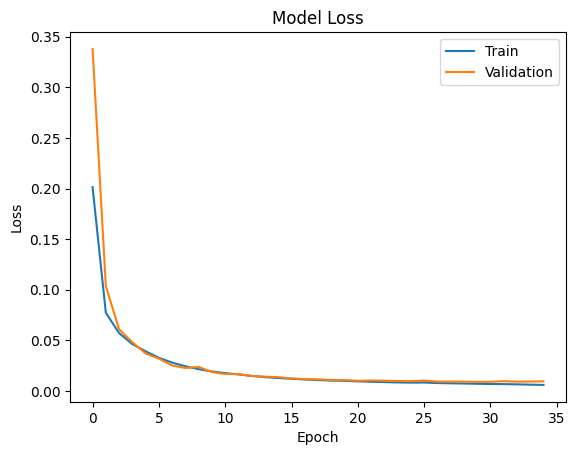

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

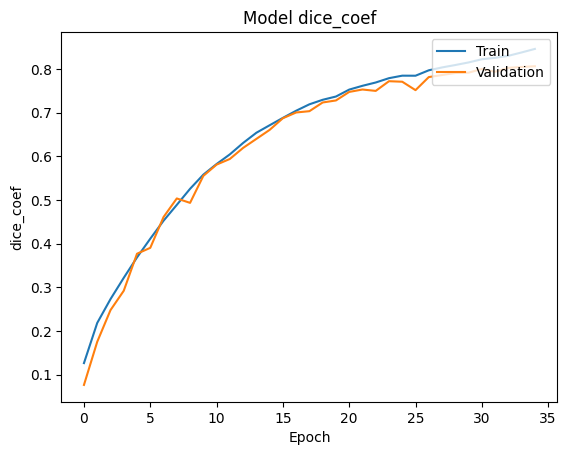

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.xlabel('Epoch')
plt.ylabel('dice_coef')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

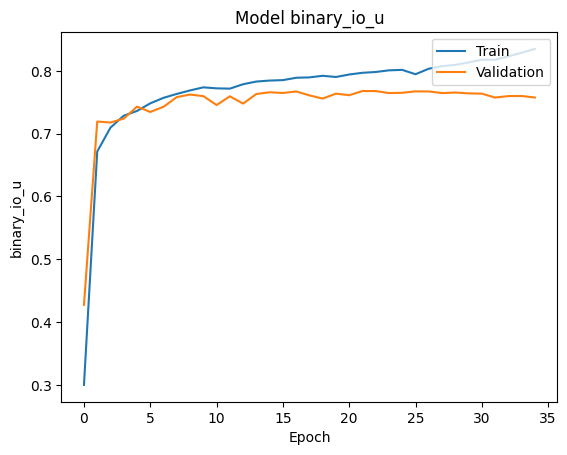

In [ ]:
plt.plot(history.history['binary_io_u'])
plt.plot(history.history['val_binary_io_u'])
plt.title('Model binary_io_u')
plt.xlabel('Epoch')
plt.ylabel('binary_io_u')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Metrics

## IoU for test dataset

In [ ]:
import pandas as pd
n_classes = 2

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().valuesp-

In [ ]:
print(f"Mean IoU for test dataset is: {round(mean_IoU[0]*100,2)}%")

Mean IoU for test dataset is: 85.52%


## Probability map

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [ ]:
y_pred = model.predict([X_test])

20/20 [==============================] - 12s 177ms/step


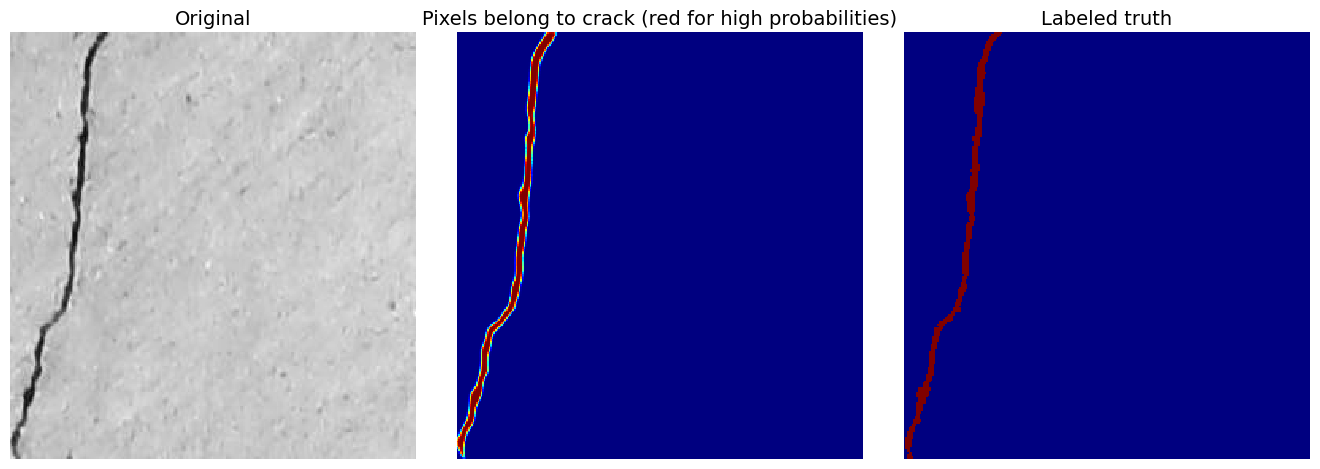

In [ ]:
i_sample = random.randint(0, X_test.shape[0]-1)

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(X_test[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_test[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to crack (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);